<a href="https://colab.research.google.com/github/heejjj/Health_Bio_AI/blob/bio_colab/pj2_brain_tumor_vgg16_0410.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install imutils
from IPython.display import clear_output
!pip install imutils wandb
clear_output()

In [ ]:
#vgg16
%matplotlib inline
import numpy as np
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
import random as rd
import os
import tensorflow_hub as hub
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from keras.metrics import accuracy
from keras.applications.vgg16 import VGG16
from keras.models import load_model
from numpy.random import seed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Nadam
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Flatten,BatchNormalization,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import ReduceLROnPlateau
import imutils

In [ ]:
!pip install -q -U keras-tuner
import keras_tuner as kt

#feat. 하이퍼파라미터 최적화(HPO, Hyper parameter optimization)
#https://www.tensorflow.org/tutorials/keras/keras_tuner?hl=ko

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.2/172.2 KB 7.8 MB/s eta 0:00:00


In [ ]:
# Define the path to the dataset
IMG_PATH = '/content/drive/MyDrive/archive/brain_tumor_dataset/'

# Create a list of all the image filenames
all_images = []
for folder in ['yes', 'no']:
    folder_path = os.path.join(IMG_PATH, folder)
    for filename in os.listdir(folder_path):
        
         all_images.append(os.path.join(folder_path, filename))

# Create a list of corresponding labels (0 for 'no', 1 for 'yes')
labels = [1 if 'Y' in filename else 0 for filename in all_images]

# Split the dataset into train, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(all_images, labels, test_size=0.03, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=123)

# Print the sizes of the resulting datasets
print(f'Train set size: {len(X_train)}')
print(f'Validation set size: {len(X_val)}')
print(f'Test set size: {len(X_test)}')

Train set size: 183
Validation set size: 62
Test set size: 8


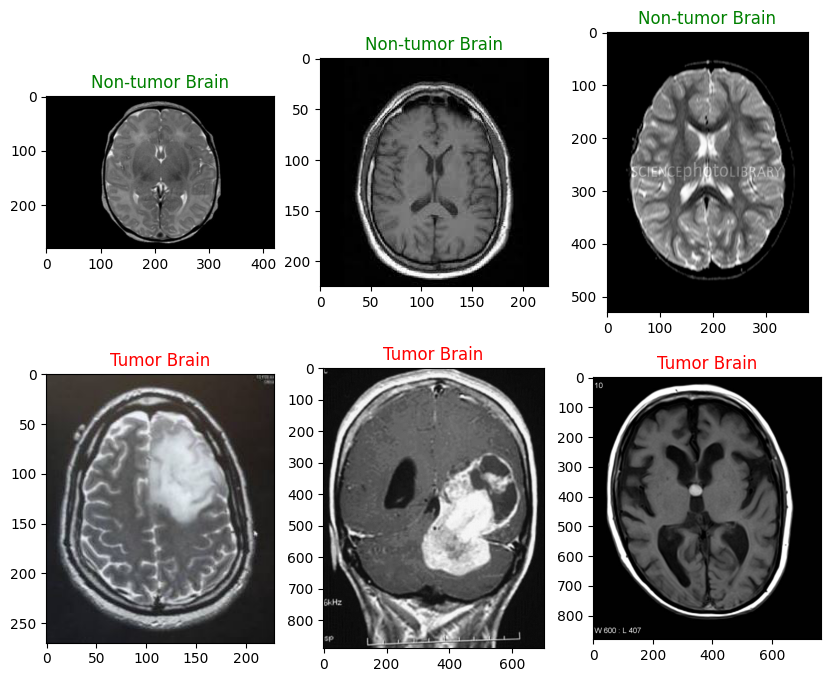

In [ ]:
%matplotlib inline

# Define the path to the dataset
IMG_PATH = '/content/drive/MyDrive/archive/brain_tumor_dataset/'

# Define the labels and their corresponding colors
labels = {0: 'Non-tumor Brain', 1: 'Tumor Brain'}
colors = {0: 'green', 1: 'red'}

# Plot some images from the train set for each label
fig, axs = plt.subplots(2, 3, figsize=(10, 8))
for i, label in enumerate([0, 1]):
    images = [x for x, y in zip(X_train, y_train) if y == label][:3]
    for j, image_path in enumerate(images):
        img = plt.imread(image_path)
        axs[i, j].imshow(img)
        axs[i, j].set_title(labels[label], color=colors[label])
plt.show()

In [ ]:
def preprocess_images(images):
    preprocessed_images = []
    for i, img_path in enumerate(images):
        img = cv2.imread(img_path)
        img = cv2.resize(
            img,
            dsize=(224,224),
            interpolation=cv2.INTER_CUBIC
        )
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)
        
        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        # crop
        ADD_PIXELS = 0
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        new_img = cv2.resize(
            new_img,
            dsize=(224,224))
        preprocessed_images.append(new_img)
    return np.array(preprocessed_images)

In [ ]:
# Apply the preprocessing to all the data subsets 
X_train_pre = preprocess_images(X_train)
X_val_pre = preprocess_images(X_val)
X_test_pre = preprocess_images(X_test)

In [ ]:
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.vgg19 import VGG19


In [ ]:
# Transform the subsets to numpy arrays 
X_train_pre_vgg = np.array([preprocess_input(image) for image in X_train_pre])
X_val_pre_vgg = np.array([preprocess_input(image) for image in X_val_pre])
X_test_pre_vgg = np.array([preprocess_input(image) for image in X_test_pre])

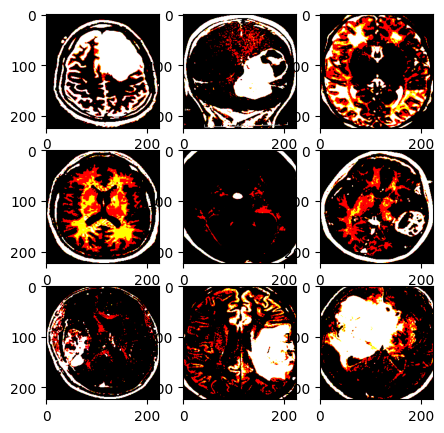

In [ ]:
# plot some images from X_train_pre
plt.figure(figsize=(5, 5))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_train_pre_vgg[i], cmap='gray')
plt.show()

In [ ]:
model.save('brain_tumor_vgg16_0410_hj.h5')
#new_model = tf.keras.models.load_model('iris.h5')

test_loss, test_acc = new_model.evaluate(x,  y, verbose=2)

NameError: ignored

In [ ]:
# Load the pre-trained VGG16 model
base_model = VGG16(
weights='imagenet',
include_top=False,
input_shape=(224,224) + (3,)
)


58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
"""# Load the pre-trained VGG16 model
base_model = VGG16(
weights='imagenet',
include_top=False,
input_shape=(224,224) + (3,)
)"""

# Create a new model by adding a few layers on top of the pre-trained model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Freeze the weights of the pre-trained model
model.layers[0].trainable = False

# Compile the model with appropriate loss function, optimizer and metrics
model.compile(
loss='binary_crossentropy',
optimizer=Adam(),
metrics=['accuracy']
)

# Print the summary of the model
model.summary()

# Define the training data generator with necessary data augmentation techniques
train_datagen = ImageDataGenerator(
rescale=1./255,
rotation_range=20,
width_shift_range=0.1,
height_shift_range=0.1,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True,
fill_mode='nearest'
)

# Create the training data generator using the training dataset and the data generator
train_generator = train_datagen.flow(
X_train_pre_vgg,
y_train,
batch_size=32
)

# Define a callback to reduce the learning rate when the validation accuracy plateaus
##모델 개선 없을 시, lr조절해 모델 개선 유도하는 call back, 
##https://deep-deep-deep.tistory.com/56

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=5, min_lr=1e-5)
#Learning rate를 얼마나 감소시킬 지 정하는 인자값입니다.
"""
예를 들어 현재 lr이 0.01이고 factor가 0.8일 때, 콜백함수가 실행된다면 그 다음 lr은 0.008이 됨.
또다른 예로 현재 lr이 0.3이고 factor가 0.1일 때, 콜백함수가 실행된다면 그 다음 lr은 0.03이 됨"""

"""
Learning rate의 하한선을 지정합니다.
예를 들어 현재 lr이 0.1이고 factor가 0.5이고, min_lr이 0.03이라면,
첫 번째로 콜백함수가 적용될 시, lr은 0.05(0.1*0.5)이 됩니다.
두 번째로 콜백함수가 적용된다면 0.025(0.1*0.5*0.5)이지만, min_lr이 0.03이기 때문에, 새로운 learning rate는 0.025가 아닌, 0.03이 됩니다.
"""
#5에폭동안 개선되지 않으면ㄴ, 학습률 0.2배 줄어듬
#최속 학습률 1e-6
#lr이 크면 발산, lr작으면 수렴속도가 느려지는 문제를 피할 수 있음


# Define a callback to stop the training when validation accuracy reaches 90%
class StopOnAccuracy(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.9:
            print("\nReached 90% accuracy, stopping training...")
            self.model.stop_training = True

# Define the validation data generator with appropriate data preprocessing
val_datagen = ImageDataGenerator(rescale=1./255)

# Create the validation data generator using the validation dataset and the data generator
val_generator = val_datagen.flow(X_val_pre_vgg, y_val, batch_size=30)

# Train the model using the training data generator, validation data generator and the defined callbacks
history = model.fit(
train_generator,
epochs=50,
validation_data=val_generator,
callbacks=[reduce_lr,StopOnAccuracy()]
)




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/50
6/6 [==============================] - 23s 2s/step - loss: 0.8346 - accuracy: 0.5246 - val_loss: 0.6731 - val_accuracy: 0.6129 - lr: 0.0010
Epoch 2/50
6/6 [====

In [ ]:
model.save('brain_tumor_vgg16_0410_hj.h5')
#new_model = tf.keras.models.load_model('brain_tumor_vgg16_0410_hj.h5')
#test_loss, test_acc = new_model.evaluate(x,  y, verbose=2)

In [ ]:
model.save('model1.h5')

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, threstholds = roc_curve(y_test, model.predict(X_test))
roc_auc = auc(fpr, tpr)
print('AUROC : ', roc_auc) 
model.save('brain_tumor_vgg16_0410_hj.h5')

ValueError: ignored

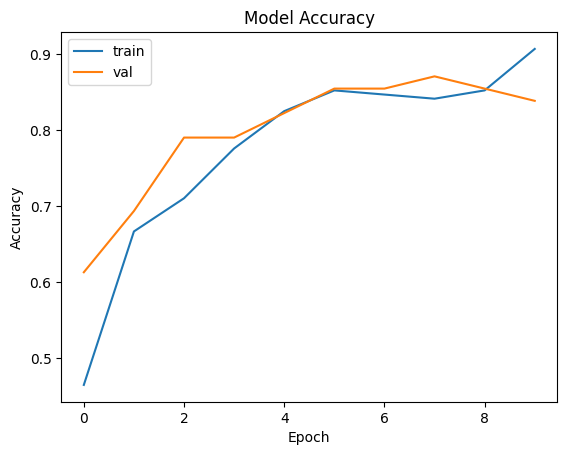

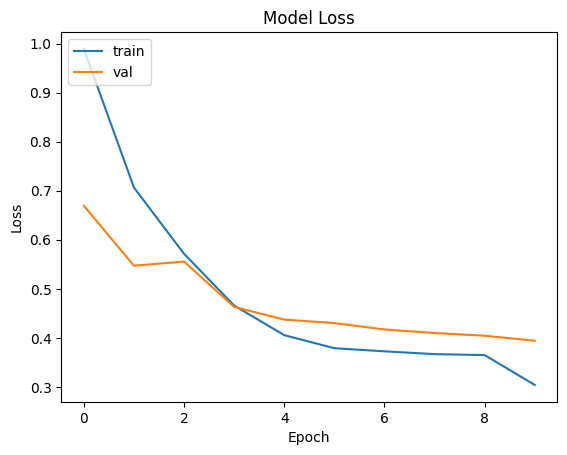

In [ ]:
# Plot the training and validation accuracy curves
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot the training and validation loss curves
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

1/1 [==============================] - 0s 51ms/step


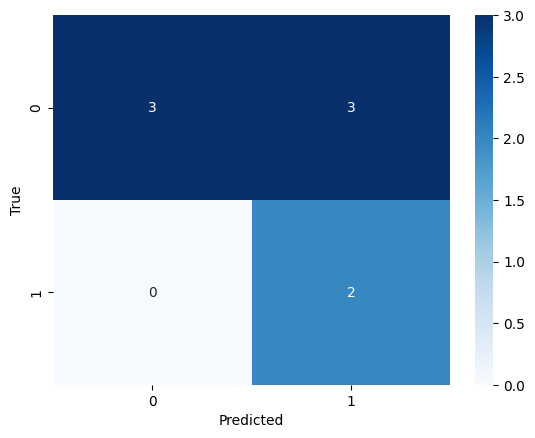

Test accuracy: 0.625


In [ ]:
# Make predictions on X_test_pre
y_pred = model.predict(X_test_pre)
y_pred = np.round(y_pred).astype(int)

# Plot confusion matrix
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Calculate accuracy on test set
test_accuracy = accuracy_score(y_test, y_pred)
print('Test accuracy:', test_accuracy)

In [ ]:
!pip install graphviz
!pip install pydot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
y_pred = model.predict(X_test)

ValueError: ignored

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, threstholds = roc_curve(y_test, model.predict(X_test))
roc_auc = auc(fpr, tpr)
print('AUROC : ', roc_auc) 

ValueError: ignored

In [ ]:
acc = history.history['test_accuracy']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
AUC = history.history['auc']
val_AUC = history.history['val_auc']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

plt.plot(epochs, AUC, 'g', label='AUC')
plt.plot(epochs, val_AUC, 'b', label='Val_AUC')
plt.xlabel('No.of epochs')
plt.ylabel('AUC')
plt.title('Training and validation AUC')
plt.legend()
plt.figure()

KeyError: ignored

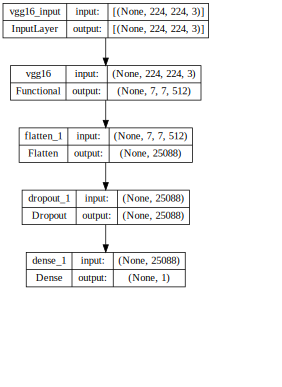

In [ ]:
#model시각화 
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
!pip install graphviz
!pip install pydot

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, threstholds = roc_curve(y_test, model.predict(x_test))
roc_auc = auc(fpr, tpr)
print('AUROC : ', roc_auc) 

NameError: ignored

In [ ]:
plt.figure(figsize=[9,7])
plt.plot(fpr, tpr, color='navy', lw=2, label='AUC (area = %0.4f' % roc_auc)
plt.plot([0,1],[0,1], color = 'black', lw=1, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Precision', fontsize=25) #FPR 정밀도 1-Specificity
plt.ylabel('Sensitivity', fontsize=25) #TPR 재현율
plt.title('ROC curve', fontsize=25)
plt.legend(loc='lower right', fontsize=23.5)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.show()

NameError: ignored

<Figure size 900x700 with 0 Axes>